# Analysis Notebook for Log Data

## Load Data from Archive

In [18]:
import os
import pickle

log_path = "./log"

data = []

for map_dir in os.listdir(log_path):
    map_path = os.path.join(log_path, map_dir)
    for dim_dir in os.listdir(map_path):
        dim_path = os.path.join(map_path, dim_dir)
        with open(dim_path, "rb") as f:
            data.append(pickle.load(f)[0])

print(data)

[{'map_name': 'random_map', 'env_dim': 35, 'start': (0, 17), 'goal': (34, 17), 'total_budget': 500000, 'per_sim_budget': 200, 'number_of_simulations': 500, 'tree_selection_method': 'ucb_child_selection', 'root_selection_method': 'epsilon_clustering_for_nodes', 'max_pareto_paths': 20, 'simulation_method': 'light_rollout', 'values': {'step_count': 142, 'weight_shifted': 56.5186651016835, 'distance_to_goal': 0}, 'path': [(0, 17), (0, 18), (1, 18), (2, 18), (2, 17), (3, 17), (4, 17), (5, 17), (6, 17), (6, 18), (6, 19), (7, 19), (7, 18), (7, 17), (8, 17), (8, 16), (9, 16), (9, 15), (10, 15), (10, 16), (10, 17), (11, 17), (12, 17), (13, 17), (14, 17), (14, 18), (14, 19), (14, 20), (15, 20), (16, 20), (17, 20), (17, 19), (17, 18), (17, 17), (18, 17), (19, 17), (20, 17), (20, 18), (21, 18), (21, 17), (20, 17), (19, 17), (18, 17), (17, 17), (17, 18), (17, 19), (17, 20), (18, 20), (18, 19), (19, 19), (19, 18), (20, 18), (20, 17), (21, 17), (22, 17), (23, 17), (24, 17), (24, 18), (23, 18), (23, 1

## Visualize the Data
- This was only used to see the data once

In [19]:
# import matplotlib.pyplot as plt

# os.mkdir("tmp/")

# for idx, (group_key, run_values) in enumerate(groups.items()):
#     # Extract the metrics
#     steps = [v["step_count"] for v in run_values]
#     weights = [v["weight_shifted"] for v in run_values]

#     # --- Plot ---
#     plt.figure(figsize=(7, 5))
#     plt.scatter(steps, weights)

#     plt.xlabel("Steps")
#     plt.ylabel("Weight Shifted")
#     plt.grid(True, alpha=0.3)

#     # Create a readable title (shortened)
#     title_params = {k: v for k, v in group_key}
#     short_title = (
#         f"{title_params['map_name']}, "
#         f"dim={title_params['env_dim']}, "
#         f"T={title_params['total_budget']}, "
#         f"sim={title_params['simulation_method']}"
#     )

#     plt.title(f"Group {idx+1}: {len(run_values)} runs\n{short_title}")

#     plt.tight_layout()
#     plt.savefig(f"./tmp/fig-{idx}.png")
#     plt.close()

#     # Also print full parameters to console for reference
#     print(f"\nGroup {idx+1} parameters:")
#     for k, v in group_key:
#         print(f"  {k}: {v}")


# Analysis for Best Parameters

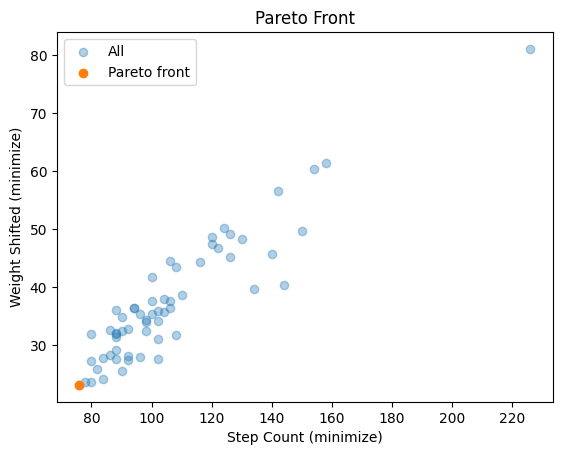

[{'map_name': 'random_map', 'env_dim': 35, 'start': (0, 17), 'goal': (34, 17), 'total_budget': 400000, 'per_sim_budget': 150, 'number_of_simulations': 300, 'tree_selection_method': 'ucb_child_selection', 'root_selection_method': 'epsilon_clustering_for_nodes', 'max_pareto_paths': 20, 'simulation_method': 'light_rollout', 'values': {'step_count': 76, 'weight_shifted': 23.115791687104014, 'distance_to_goal': 0}, 'path': [(0, 17), (1, 17), (2, 17), (3, 17), (4, 17), (5, 17), (6, 17), (7, 17), (8, 17), (8, 16), (9, 16), (10, 16), (10, 17), (11, 17), (12, 17), (13, 17), (14, 17), (15, 17), (16, 17), (17, 17), (18, 17), (19, 17), (20, 17), (21, 17), (22, 17), (23, 17), (24, 17), (25, 17), (26, 17), (27, 17), (28, 17), (29, 17), (29, 18), (30, 18), (31, 18), (32, 18), (32, 19), (33, 19), (33, 18), (33, 17), (34, 17), (33, 17), (32, 17), (31, 17), (30, 17), (29, 17), (28, 17), (27, 17), (26, 17), (25, 17), (24, 17), (23, 17), (22, 17), (21, 17), (20, 17), (19, 17), (18, 17), (17, 17), (16, 17)

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt


# steps = []
# weight_shifted = []
# for datapoint in data:
#     print(datapoint)
#     values = datapoint["values"]
#     steps.append(values["step_count"])
#     weight_shifted.append(values["weight_shifted"])

# plt.figure()
# plt.scatter(steps, weight_shifted)
# plt.xlabel("Step Count")
# plt.ylabel("Weight Shifted")
# plt.title("Step Count vs Weight Shifted")
# plt.show()

def dominates(a, b):
    """True if a dominates b (minimize both step_count and weight_shifted)."""
    a_steps = a["values"]["step_count"]
    a_w     = a["values"]["weight_shifted"]
    b_steps = b["values"]["step_count"]
    b_w     = b["values"]["weight_shifted"]

    return (a_steps <= b_steps and a_w <= b_w) and (a_steps < b_steps or a_w < b_w)

# ---- Pareto front as FULL dicts ----
pareto = []
for x in data:
    if any(dominates(y, x) for y in data if y is not x):
        continue
    pareto.append(x)

# optional: sort for nicer plotting (by step_count)
pareto.sort(key=lambda d: d["values"]["step_count"])

# ---- Plot ----
plt.figure()
plt.scatter(
    [d["values"]["step_count"] for d in data],
    [d["values"]["weight_shifted"] for d in data],
    alpha=0.35,
    label="All"
)
plt.scatter(
    [d["values"]["step_count"] for d in pareto],
    [d["values"]["weight_shifted"] for d in pareto],
    label="Pareto front"
)
plt.plot(
    [d["values"]["step_count"] for d in pareto],
    [d["values"]["weight_shifted"] for d in pareto],
)
plt.xlabel("Step Count (minimize)")
plt.ylabel("Weight Shifted (minimize)")
plt.title("Pareto Front")
plt.legend()
plt.show()
print(pareto)

